# FACE MASK DETECTION USING KERAS MODEL

In [1]:
# Importing necessary Python Modules:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os 


In [2]:
# initialize the initial learning Rate, number of Epochs and Batch size

iniLR = 1e-4
Epochs = 5
BS  = 32

In [3]:
# Creating data and LAbels 
data = []
labels = []

for category in os.listdir('directory'):
    path = os.path.join('directory', category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image= load_img(img_path, target_size= (224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

print(labels[:10])


['Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask']


In [4]:
# Perform one hot encoding on the labels 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data , dtype= 'float32')
labels = np.array(labels)

In [5]:
labels [:10 ]

# 1 represent = mask 
# 2 represent = non mask

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
# Creating Train Test dataset:

x_train, x_test , y_train , y_test = train_test_split (data, labels, test_size= 0.2, stratify= labels , random_state= 42)

In [7]:
# Construct the training image generators for data augmentation 
aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [8]:
# load the MObileNetV2 network, ensuring the head FC layer sets are left off:

baseModel = MobileNetV2 (weights = 'imagenet', include_top= False, input_tensor= Input(shape=(224,224,3)))


In [9]:
# Construct the head of the model that will be placed oon the top of the base model: 

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name = 'flatten')(headModel)
headModel = Dense(128, activation= 'relu')(headModel)
headModel = Dropout(0.5) (headModel)
headModel = Dense(2, activation= "softmax" )(headModel)

In [10]:
# Placing the head FC model in the top of base model 
# THIS WILL BE OUR ACTUAL MODEL WE WILL TRAIN

model = Model(inputs = baseModel.input, outputs = headModel)

In [11]:
# Loop over all the layers in the base model and freeze them so they will not be updated during the first training process 
\
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
# COMPILING our MODEL:

print ("[INFO] compiling model..")
opt = Adam(lr = iniLR, decay = iniLR/Epochs)
model.compile(
    loss= 'binary_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)

[INFO] compiling model..


C:\Users\skyya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# Train the head of the Network: 
print ("[INFO] Training Head..")

H = model.fit(
    aug.flow(x_train,y_train,batch_size= BS),
    steps_per_epoch = len(x_train)//BS,
    validation_data = (x_test,y_test),
    validation_steps = len(x_test)//BS,
    epochs = Epochs
)

[INFO] Training Head..
Epoch 1/5
25/25 [==============================] - 34s 1s/step - loss: 0.6794 - accuracy: 0.6490 - val_loss: 0.4364 - val_accuracy: 0.8960
Epoch 2/5
25/25 [==============================] - 29s 1s/step - loss: 0.4072 - accuracy: 0.8821 - val_loss: 0.2700 - val_accuracy: 0.9604
Epoch 3/5
25/25 [==============================] - 31s 1s/step - loss: 0.2673 - accuracy: 0.9352 - val_loss: 0.1893 - val_accuracy: 0.9703
Epoch 4/5
25/25 [==============================] - 30s 1s/step - loss: 0.2008 - accuracy: 0.9560 - val_loss: 0.1410 - val_accuracy: 0.9802
Epoch 5/5
25/25 [==============================] - 32s 1s/step - loss: 0.1702 - accuracy: 0.9650 - val_loss: 0.1186 - val_accuracy: 0.9752


In [14]:
# Make predictions :
print ("[INFO]  evaluating network")
predict = model.predict(x_test,batch_size=BS)

# for each of the images in the testing set  we need to find the index of the LAbels  with corresponding Largest Pridicted possibility:

predict = np.argmax(predict,axis =1)

[INFO]  evaluating network


In [15]:
# Show a nicely formatted classificaation report: 
print (classification_report(y_test.argmax(axis= 1),predict, target_names= lb.classes_))

              precision    recall  f1-score   support

        Mask       0.95      1.00      0.98       101
    Non Mask       1.00      0.95      0.97       101

    accuracy                           0.98       202
   macro avg       0.98      0.98      0.98       202
weighted avg       0.98      0.98      0.98       202



In [16]:
# serialize the model to disk

print('[INFO] saving mask detector model...')
model.save("mask_detector.model", save_format= 'h5')

[INFO] saving mask detector model...


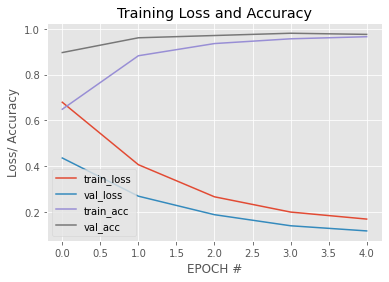

In [17]:
# plot the training loss and accuracy:

N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0,N), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0,N), H.history['accuracy'], label ='train_acc')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label= 'val_acc')

plt.title("Training Loss and Accuracy")
plt.xlabel("EPOCH #")
plt.ylabel("Loss/ Accuracy")
plt.legend(loc = 'lower left')
plt.savefig('plot.png')